# Deep Neural Network for Sign Language Digits Dataset

## 1: Data and Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Load Sign Language Digits Dataset

In [2]:
X = np.load('X.npy')
Y = np.load('Y.npy')

In [3]:
X.shape, Y.shape

((2062, 64, 64), (2062, 10))

In [4]:
temp = -1
l = []
for i in Y:
    val = np.argmax(i)
    l.append(val)

In [5]:
# converting to torch tensors
Y_t = torch.tensor(l)
X_t = torch.from_numpy(X)
X_t = X_t.unsqueeze(1)

In [6]:
X_t.shape, Y_t.shape

(torch.Size([2062, 1, 64, 64]), torch.Size([2062]))

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(X_t, Y_t, stratify = Y_t, shuffle = True, train_size = 0.8)

In [8]:
ytrain.unique(), ytest.unique()

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

In [9]:
Counter(ytrain.numpy()), Counter(ytest.numpy())

(Counter({9: 165,
          1: 164,
          7: 165,
          3: 166,
          0: 163,
          5: 166,
          2: 165,
          8: 165,
          4: 165,
          6: 165}),
 Counter({9: 42,
          5: 42,
          1: 41,
          3: 41,
          7: 41,
          2: 41,
          6: 42,
          0: 41,
          4: 41,
          8: 41}))

In [10]:
def combine(x, y):
    ''' function to combine X troch tensor and Y torch tensors for traning purpose'''
    combined = []
    for i, j in zip(x,y):
        combined.append((i, j))
    return combined

In [11]:
data_train = combine(xtrain, ytrain)
data_test = combine(xtest, ytest)

In [12]:
len(data_train)

1649

<class 'torch.Tensor'> tensor(9)


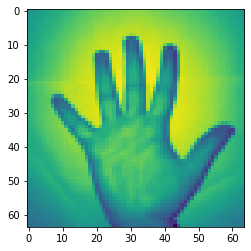

In [13]:
print(type(data_train[0][0]),data_train[0][1])
plt.imshow(data_train[0][0].numpy().squeeze())

In [14]:
input_size  = 64*64   # images are 64x64 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(data_train, batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(data_test, batch_size=128, shuffle=True)

torch.Size([128, 1, 64, 64]) torch.Size([128])


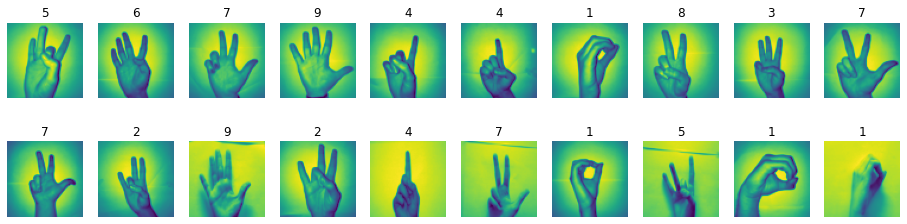

In [15]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))
print(image_batch.shape, label_batch.shape)
for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

In [16]:
label_batch.unique() #10 classes in Sign Language Digits dataset

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

We have 10 different Classes

## 2: A Fully Connected Neural Network


### Helper functions for training and testing

In [17]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

### Defining the Fully Connected Network

In [18]:
class FC2Layer(nn.Module):
    def __init__(self, input_size, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, 512), 
            nn.ReLU(), 
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,64), 
            nn.ReLU(),
            nn.Linear(64,32), 
            nn.ReLU(), 
            nn.Linear(32,16), 
            nn.ReLU(), 
            nn.Linear(16, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

### Train the Network

In [19]:
print("Training on ", device)
model_fnn = FC2Layer(input_size, output_size)
model_fnn.to(device)
optimizer = optim.Adam(model_fnn.parameters())
print('Number of parameters: {}\n'.format(get_n_params(model_fnn)))

for epoch in range(0, 100):
    train(epoch, model_fnn)
    print('Epoch:',epoch)
    test(model_fnn)
    print('\n')

Training on  cpu
Number of parameters: 2174362

Epoch: 0
Average loss: 2.3082, Accuracy: 43/413 (10%)


Epoch: 1
Average loss: 2.3095, Accuracy: 41/413 (10%)


Epoch: 2
Average loss: 2.3027, Accuracy: 41/413 (10%)


Epoch: 3
Average loss: 2.2967, Accuracy: 77/413 (19%)


Epoch: 4
Average loss: 2.2765, Accuracy: 57/413 (14%)


Epoch: 5
Average loss: 2.2276, Accuracy: 72/413 (17%)


Epoch: 6
Average loss: 2.2161, Accuracy: 60/413 (15%)


Epoch: 7
Average loss: 2.0885, Accuracy: 108/413 (26%)


Epoch: 8
Average loss: 2.0561, Accuracy: 85/413 (21%)


Epoch: 9
Average loss: 2.1263, Accuracy: 77/413 (19%)


Epoch: 10
Average loss: 2.1052, Accuracy: 82/413 (20%)


Epoch: 11
Average loss: 2.0134, Accuracy: 115/413 (28%)


Epoch: 12
Average loss: 1.9753, Accuracy: 115/413 (28%)


Epoch: 13
Average loss: 1.8989, Accuracy: 124/413 (30%)


Epoch: 14
Average loss: 1.8580, Accuracy: 140/413 (34%)


Epoch: 15
Average loss: 1.8932, Accuracy: 115/413 (28%)


Epoch: 16
Average loss: 1.7619, Accuracy: 14

### Show some predictions of the test network

In [20]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    pred_label = np.argmax(pred_prob)
    ax1.set_title([real_label, pred_label])
    
    ax2.barh(np.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

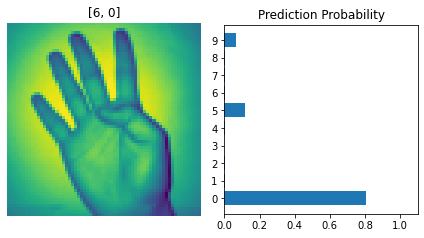

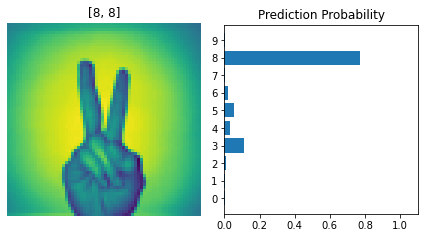

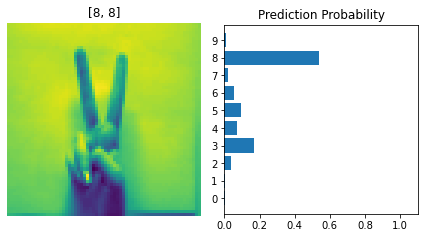

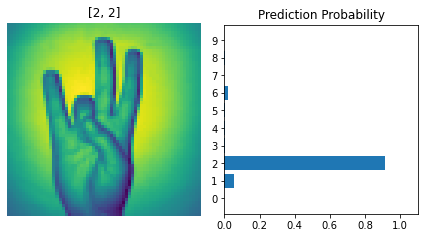

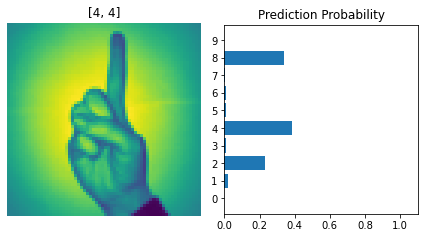

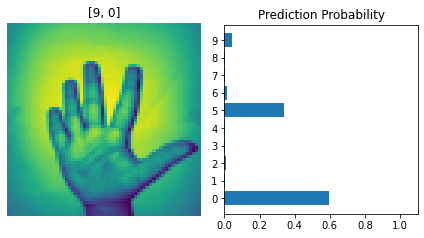

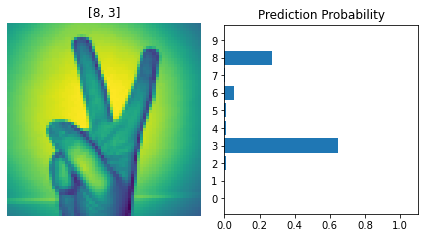

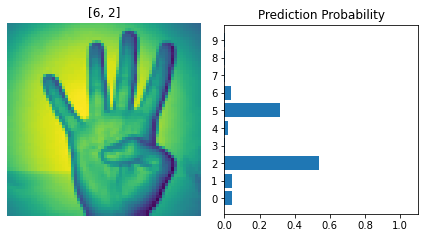

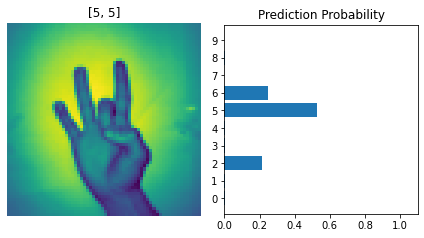

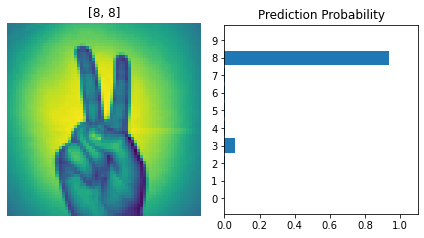

In [21]:
model_fnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

## 3 : Does the Fully Connected Network use "Visual Information" ?

### Making permutations (Scramble) of dataset to create new point with no visual information

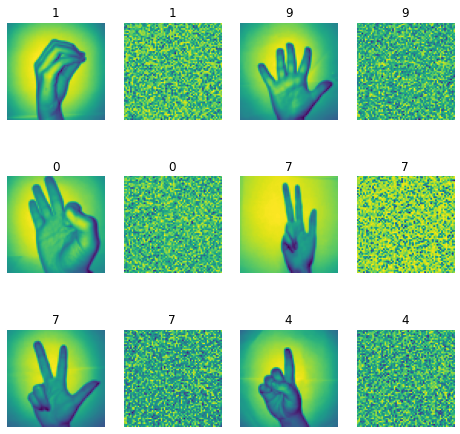

In [25]:
fixed_perm = torch.randperm(64*64) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 64*64).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 64, 64)
    
    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)


We can see that the permutated data point does not contain any visual information. Now we will use these new point to answer our question.

### Helper function for Scramble images.

In [30]:
accuracy_list = []

def scramble_train(epoch, model, perm=torch.arange(0,64*64).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 64*64)
        data = data[:, perm]
        data = data.view(-1, 1, 64, 64)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
            
def scramble_test(model, perm=torch.arange(0, 64*64).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 64*64)
        data = data[:, perm]
        data = data.view(-1, 1, 64, 64)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

### Train the Network

In [31]:
print("Training on ", device)
model_fnn_2 = FC2Layer(input_size, output_size)
model_fnn_2.to(device)
optimizer = optim.Adam(model_fnn_2.parameters())
print('Number of parameters: {}\n'.format(get_n_params(model_fnn_2)))

for epoch in range(0, 100):
    scramble_train(epoch, model_fnn_2, fixed_perm)
    print('Epoch:',epoch)
    scramble_test(model_fnn_2, fixed_perm)
    print('\n')

Training on  cpu
Number of parameters: 2174362

Epoch: 0
Average loss: 2.3089, Accuracy: 41/413 (10%)


Epoch: 1
Average loss: 2.3045, Accuracy: 41/413 (10%)


Epoch: 2
Average loss: 2.3050, Accuracy: 42/413 (10%)


Epoch: 3
Average loss: 2.3028, Accuracy: 67/413 (16%)


Epoch: 4
Average loss: 2.3009, Accuracy: 42/413 (10%)


Epoch: 5
Average loss: 2.2978, Accuracy: 59/413 (14%)


Epoch: 6
Average loss: 2.2916, Accuracy: 50/413 (12%)


Epoch: 7
Average loss: 2.2724, Accuracy: 73/413 (18%)


Epoch: 8
Average loss: 2.2222, Accuracy: 76/413 (18%)


Epoch: 9
Average loss: 2.1301, Accuracy: 80/413 (19%)


Epoch: 10
Average loss: 2.1564, Accuracy: 75/413 (18%)


Epoch: 11
Average loss: 1.9838, Accuracy: 99/413 (24%)


Epoch: 12
Average loss: 1.9266, Accuracy: 96/413 (23%)


Epoch: 13
Average loss: 1.8239, Accuracy: 112/413 (27%)


Epoch: 14
Average loss: 1.8694, Accuracy: 118/413 (29%)


Epoch: 15
Average loss: 1.7894, Accuracy: 132/413 (32%)


Epoch: 16
Average loss: 1.8908, Accuracy: 109/4

Model still gives good accuracy on Scramble images, So DNNs doesn't use visual information.

### Show some predictions of the test network

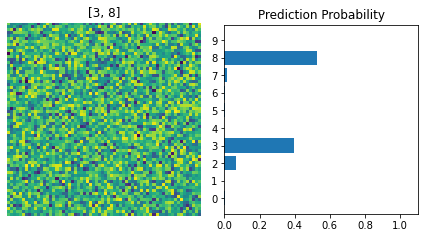

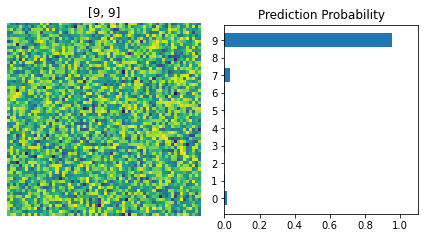

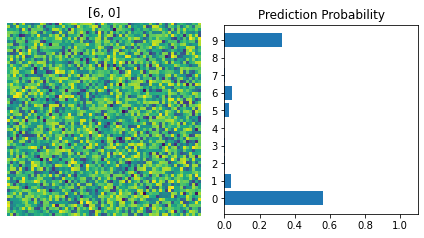

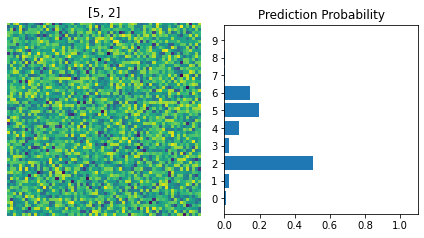

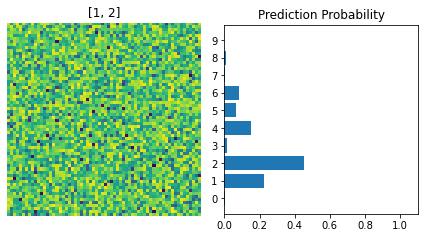

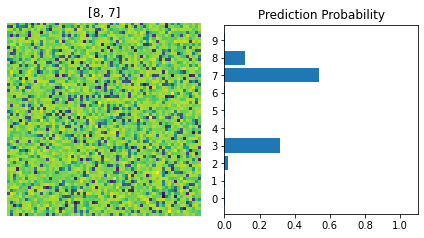

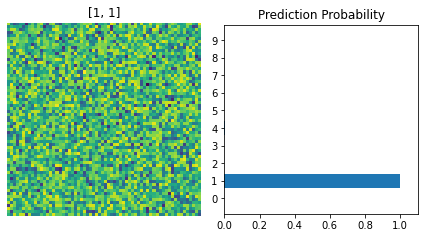

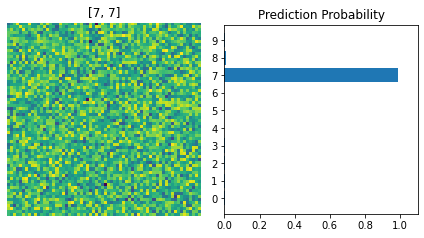

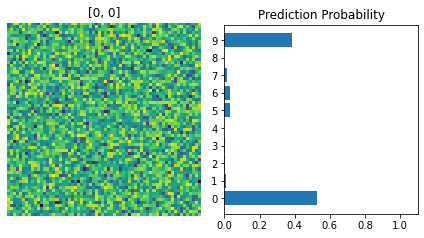

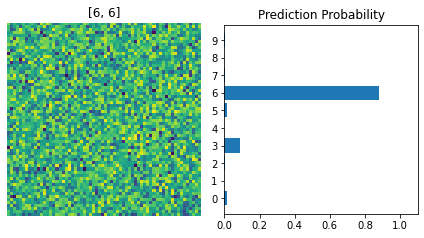

In [32]:
model_fnn_2.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 64*64)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 64, 64)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_fnn_2(image_batch_scramble)
for i in range(10):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label)

# Convolutional Neural Network for Sign Language Digits Dataset

## 1 : A Convolutional Neural Network

### Helper functions for training and testing

Same as in DNN model

### Defining a Convolutional Neural Network

In [33]:
class CNNDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(32*11*11, 200)
        self.do1 = nn.Dropout2d(p=0.8)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 32*11*11)
        x = self.fc1(x)
        x = self.do1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [34]:
model_2 = CNNDropout(input_size, output_size)
for i in list(model_2.parameters()):
    print(i.shape)

torch.Size([12, 1, 3, 3])
torch.Size([12])
torch.Size([24, 12, 6, 6])
torch.Size([24])
torch.Size([32, 24, 6, 6])
torch.Size([32])
torch.Size([200, 3872])
torch.Size([200])
torch.Size([10, 200])
torch.Size([10])


In [35]:
for data, target in train_loader:
    print(data.shape, target.shape)
    break

torch.Size([128, 1, 64, 64]) torch.Size([128])


In [38]:
print("Training on ", device)
model_2 = CNNDropout(input_size, output_size)
model_2.to(device)
optimizer = optim.Adam(model_2.parameters())
print('Number of parameters: {}\n'.format(get_n_params(model_2)))

for epoch in range(0, 25):
    model_2.train() # model in training mode. Turns on dropout, batch-norm etc during training
    train(epoch, model_2)
    print('Epoch:',epoch)
    model_2.eval() # model in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
    test(model_2)
    print('\n')

Training on  cpu
Number of parameters: 814802

Epoch: 0
Average loss: 2.3019, Accuracy: 63/413 (15%)


Epoch: 1
Average loss: 2.2372, Accuracy: 145/413 (35%)


Epoch: 2
Average loss: 1.6249, Accuracy: 215/413 (52%)


Epoch: 3
Average loss: 1.3076, Accuracy: 272/413 (66%)


Epoch: 4
Average loss: 1.1086, Accuracy: 295/413 (71%)


Epoch: 5
Average loss: 0.8681, Accuracy: 324/413 (78%)


Epoch: 6
Average loss: 0.7350, Accuracy: 328/413 (79%)


Epoch: 7
Average loss: 0.6457, Accuracy: 340/413 (82%)


Epoch: 8
Average loss: 0.6235, Accuracy: 344/413 (83%)


Epoch: 9
Average loss: 0.5473, Accuracy: 352/413 (85%)


Epoch: 10
Average loss: 0.5131, Accuracy: 344/413 (83%)


Epoch: 11
Average loss: 0.4881, Accuracy: 351/413 (85%)


Epoch: 12
Average loss: 0.4614, Accuracy: 354/413 (86%)


Epoch: 13
Average loss: 0.4415, Accuracy: 356/413 (86%)


Epoch: 14
Average loss: 0.4300, Accuracy: 360/413 (87%)


Epoch: 15
Average loss: 0.4057, Accuracy: 357/413 (86%)


Epoch: 16
Average loss: 0.4014, Accu

### Show some predictions of the test network

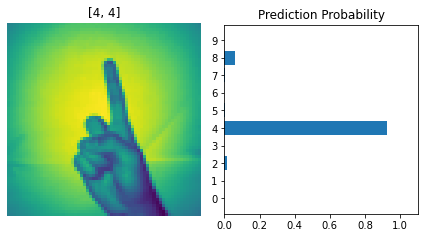

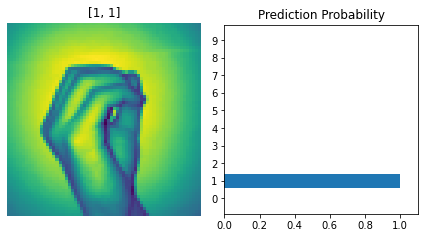

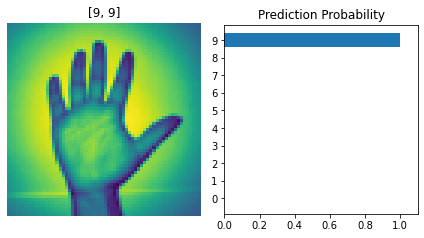

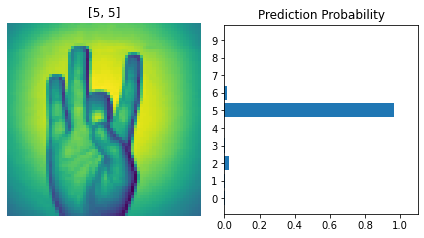

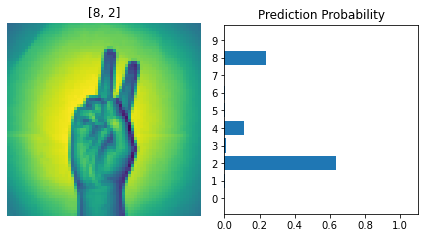

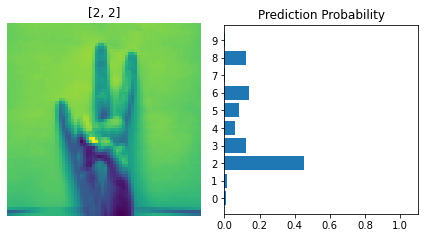

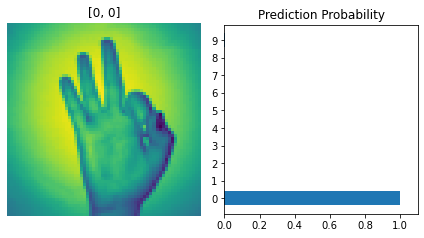

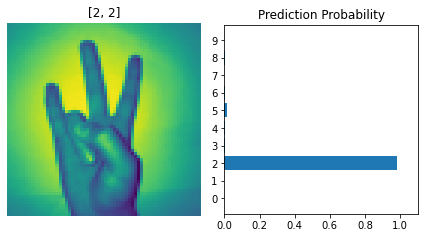

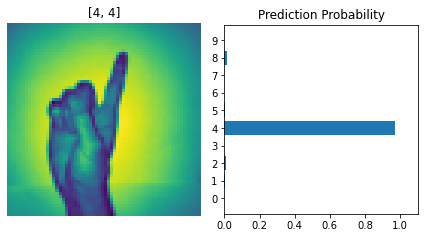

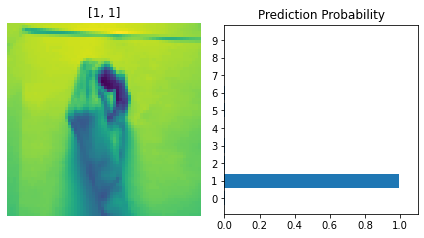

In [39]:
model_2.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_2(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

## 2 : Does the Convolutional Neural Network use "Visual Information" ?


### Making permutations (Scramble) of dataset to create new point with no visual information

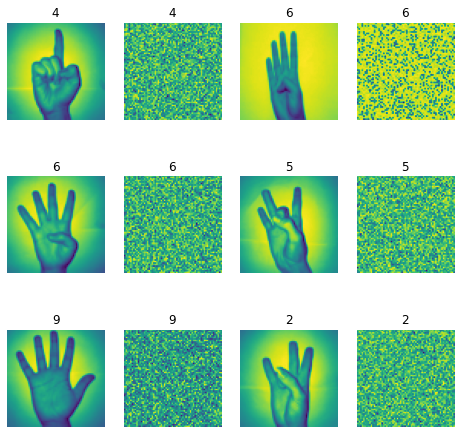

In [40]:
fixed_perm = torch.randperm(64*64) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 64*64).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 64, 64)
    
    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

### Helper function for Scramble images.

Same as in DNN model

### Train the Network

In [42]:
print("Training on ", device)
model_cnn_3 = CNNDropout(input_size, output_size)
model_cnn_3.to(device)
optimizer = optim.SGD(model_cnn_3.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_3)))

for epoch in range(0, 20):
    scramble_train(epoch, model_cnn_3, fixed_perm)
    print('Epoch:',epoch)
    scramble_test(model_cnn_3, fixed_perm)
    print('\n')

Training on  cpu
Number of parameters: 814802
Epoch: 0
Average loss: 2.3032, Accuracy: 42/413 (10%)


Epoch: 1
Average loss: 2.3031, Accuracy: 42/413 (10%)


Epoch: 2
Average loss: 2.3030, Accuracy: 42/413 (10%)


Epoch: 3
Average loss: 2.3029, Accuracy: 42/413 (10%)


Epoch: 4
Average loss: 2.3028, Accuracy: 42/413 (10%)


Epoch: 5
Average loss: 2.3028, Accuracy: 42/413 (10%)


Epoch: 6
Average loss: 2.3028, Accuracy: 42/413 (10%)


Epoch: 7
Average loss: 2.3027, Accuracy: 42/413 (10%)


Epoch: 8
Average loss: 2.3027, Accuracy: 42/413 (10%)


Epoch: 9
Average loss: 2.3025, Accuracy: 42/413 (10%)


Epoch: 10
Average loss: 2.3025, Accuracy: 42/413 (10%)


Epoch: 11
Average loss: 2.3024, Accuracy: 42/413 (10%)


Epoch: 12
Average loss: 2.3024, Accuracy: 42/413 (10%)


Epoch: 13
Average loss: 2.3024, Accuracy: 44/413 (11%)


Epoch: 14
Average loss: 2.3023, Accuracy: 46/413 (11%)


Epoch: 15
Average loss: 2.3022, Accuracy: 42/413 (10%)


Epoch: 16
Average loss: 2.3023, Accuracy: 42/413 (10

Model's accuracy is decreased drastically, So CNNs uses visual information.

### Show some predictions of the test network

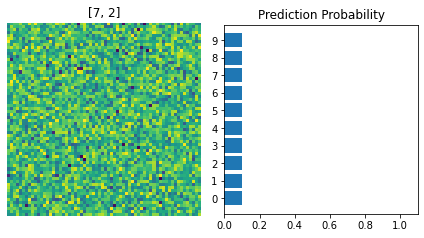

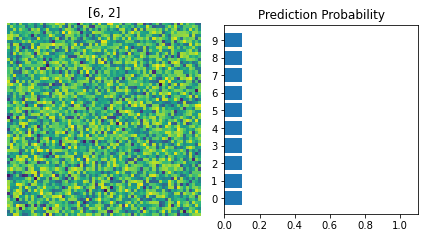

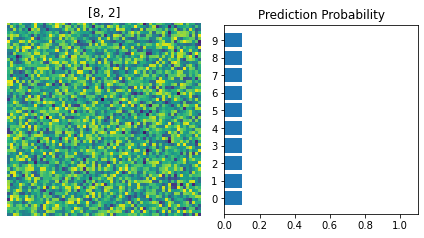

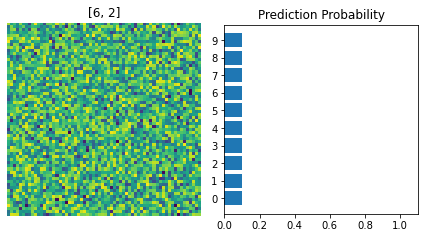

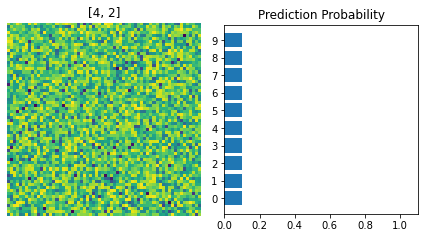

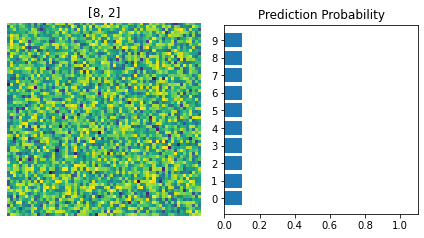

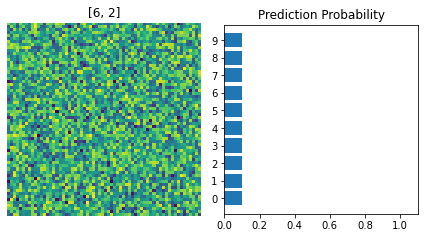

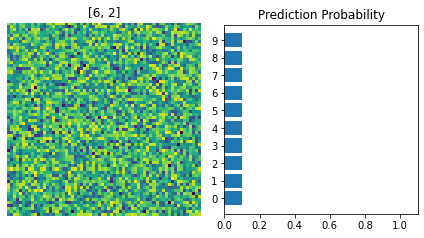

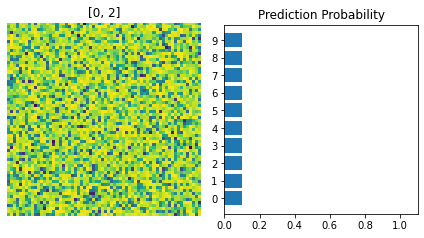

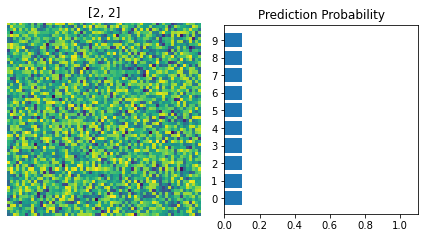

In [43]:
model_cnn_3.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 64*64)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 64, 64)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn_3(image_batch_scramble)
for i in range(10):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label)

# Observations:
|Model |  Scrambled | Accuracy (%)|
|------|------------|---------|
|DNN|No|69|
|DNN|Yes|71|
|CNN|No|90|
|CNN|Yes|10| 

# Conclusions:

CNN performs much better than DNN. In case of Scrambled data DNN is still classifying with same accuracy while CNN is misclassifying these points.

So, Only CNN uses visual information.